In [37]:
using JLD2, Flux, CairoMakie, Random

# Including necessary custom modules
include("DenseNTk.jl")
include("FastNTKMethods.jl")

# Setting a random seed for reproducibility
Random.seed!(123)

# Generating input data (3 input dimensions, 10 samples)
x = zeros(3, 10)
x[1, :] = randn(10)
x[2, :] = randn(10)
x[3, :] = randn(10)

# Defining the function g(x, y, z)
function g(x)
    term1 = exp.(cos.(x[1, :] * π) .+ sin.(x[2, :] * π) .+ tan.(x[3, :] * π))
    term2 = tanh.(x[1, :] .+ x[3, :])
    g = zeros(2,size(x)[2])
    g[1,:] = term1; g[2,:] = term2
    return g
end

# Generate output using function g
y = g(x)

# Model parameters
activation = relu
N1 = 10_000
InDim = size(x)[1]
OutDim = size(y)[1]  # Output dimension is 2

# Defining the model
model = Chain(DenseNTK(InDim => N1, activation), DenseNTK(N1 => OutDim)) |> f64
params_0 = deepcopy(Flux.params(model))

# Loss function
Loss(model, x, y) = Flux.mse(y, model(x))
data = [(x, y)]
n_epoch = 10_000

# Calculating kernel and learning rates
K = kernel(model, x, false)
eig = eigen(K).values

Loss(model,x,y)
display(model)

# Training with lr_opt1
L = []
@showprogress for epoch = 1:n_epoch
    if epoch <= 300
        Flux.train!(Loss, model, data, Descent(1/eig[end]))
    elseif epoch > 300 && epoch <= 600
        Flux.train!(Loss, model, data, Descent(1/eig[end-1]))

    elseif epoch > 600
        Flux.train!(Loss, model, data, Descent(1/eig[end-2]))
    end
    

    push!(L, Loss(model, x, y))
end






Chain(
  DenseNTK([1.0431911945343018 -2.0352120399475098 -1.6999808549880981; -0.35230258107185364 0.7574014067649841 -0.5804301500320435; … ; 1.3544707298278809 -1.1916029453277588 1.4434690475463867; 0.21149395406246185 0.8383378982543945 -1.13264799118042], [0.5359872579574585, -1.0845160484313965, 1.2176330089569092, 0.5898498296737671, -0.3037812113761902, 0.38609570264816284, -0.40988537669181824, -1.433569312095642, 0.40222325921058655, 0.09347738325595856  …  0.007402824703603983, 2.1261134147644043, 0.24825486540794373, -1.1125012636184692, 0.10441557317972183, 0.666742742061615, -0.3252783417701721, -0.7709391713142395, 0.28852570056915283, -1.0616557598114014], NNlib.relu),  # 40_000 parameters
  DenseNTK([-0.9083029627799988 1.0871212482452393 … -1.6552683115005493 0.9728426337242126; -0.5590816140174866 1.2220712900161743 … -0.7202682495117188 -0.6718257665634155], [0.5724971890449524, 1.7181426286697388], identity),  # 20_002 parameters
)                   # Total: 4 arr

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


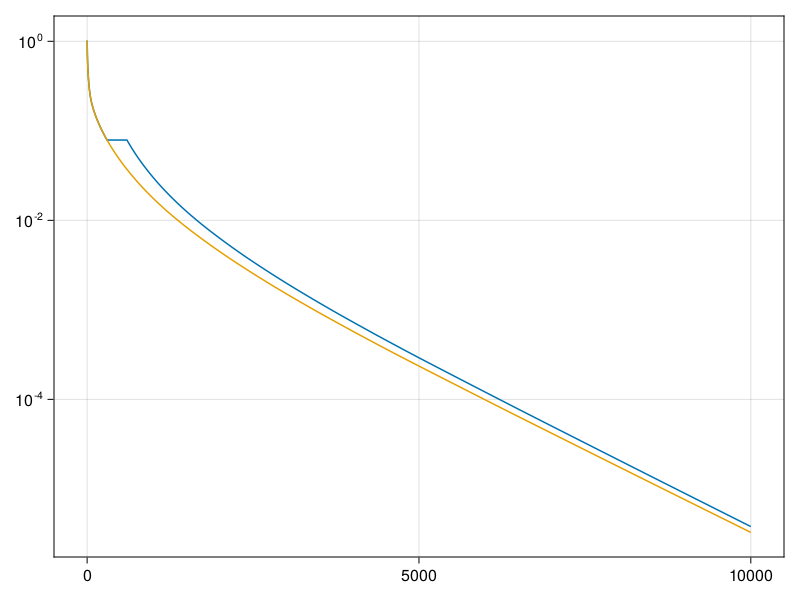

In [35]:
fig = Figure(); ax = Axis(fig[1,1],yscale = log10); CairoMakie.lines!(ax,Float64.(hcat(1:10000))[:],Float64.(L)[:])
CairoMakie.lines!(ax,Float64.(hcat(1:10000))[:],Float64.(L_opt1)[:])
fig

In [36]:
L

10000-element Vector{Any}:
 1.0184784157097009
 0.888031627017962
 0.7941096301153586
 0.7246256767995364
 0.6716405691667207
 0.6299245133881943
 0.5960274099618386
 0.5676584293896871
 0.543284968486754
 0.521883745576132
 ⋮
 3.819007883370554e-6
 3.815735720978654e-6
 3.81246258252069e-6
 3.809188073039704e-6
 3.8059409719468735e-6
 3.8026634046793533e-6
 3.799406049733723e-6
 3.7961425928669927e-6
 3.792895397375759e-6